# Classifying CIFAR10 images using a ResNet and Regularization techniques in PyTorch
### Training an image classifier from scratch to over 90% accuracy in the fastest possible time depending on the GPU

In this tutorial, we'll use the following techniques to achieve over 90% accuracy in the fastest possible time:
* Data normalization
* Data augmentation
* Residual connections
* Batch normalization
* Learning rate annealing
* Weight Decay
* Gradient clipping

## Preparing the Data
Let's begin by downloading the dataset and creating PyTorch datasets to load the data.

In [1]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url

In [2]:
# Dowload the dataset
dataset_url = "http://files.fast.ai/data/cifar10.tgz"
download_url(dataset_url, '.')

# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')
        
data_dir = './data/cifar10'

# Look inside the dataset directory
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

  0%|          | 0/168168549 [00:00<?, ?it/s]

168173568it [00:01, 100256089.76it/s]                               


['labels.txt', 'train', 'test']
['airplane', 'deer', 'dog', 'ship', 'frog', 'bird', 'truck', 'horse', 'cat', 'automobile']


There are a few of important changes we'll make while creating the PyTorch datasets:

1. Instead of setting aside a fraction (e.g. 10%) of the data from the training set for validation, we'll simply use the test set as our validation set. This just gives a little more data to train with.

2. We will normalize the image tensors by subtracting the mean and dividing by the standard deviation across each channel. As a result, the mean of the data across each channel is 0, and standard deviation is 1. Normalizing the data prevents the values from any one channel from disproportionately affecting the losses and gradients while training, simply by having a higher or wider range of values that others.

3. We will apply randomly chosen transformations while loading images from the training dataset. Specifically, we will pad each image by 4 pixels, and then take a random crop of size 32 x 32 pixels, and then flip the image horizontally with a 50% probability. Since the transformation will be applied randomly and dynamically each time a particular image is loaded, the model sees slightly different images in each epoch of training, which allows it generalize better.

<img src="https://imgaug.readthedocs.io/en/latest/_images/cropandpad_percent.jpg">

In [8]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt

In [9]:
# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         tt.ToTensor(), 
                         tt.Normalize(*stats)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [10]:
# PyTorch datasets
train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/test', valid_tfms)

Next, we can create data loaders for retrieving images in batches.

In [11]:
from torch.utils.data import DataLoader

In [12]:
batch_size = 256

In [50]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, 
                      num_workers=8, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, shuffle=False, 
                      num_workers=8, pin_memory=True)

The `num_workers` argument can be used to leverage multiple CPU cores and load images in parallel. The `pin_memory` argument avoid repeated memory allocation and deallocation by using the same portion of memory (RAM) for loading each batch of data. We are able to do this because all images have the same size (32px x 32px). These small changes in our pipeline lead to significant performance gains.

Before we proceed, let's take a look at one batch of data.

In [54]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [57]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:100], 10).permute(1, 2, 0))
        break

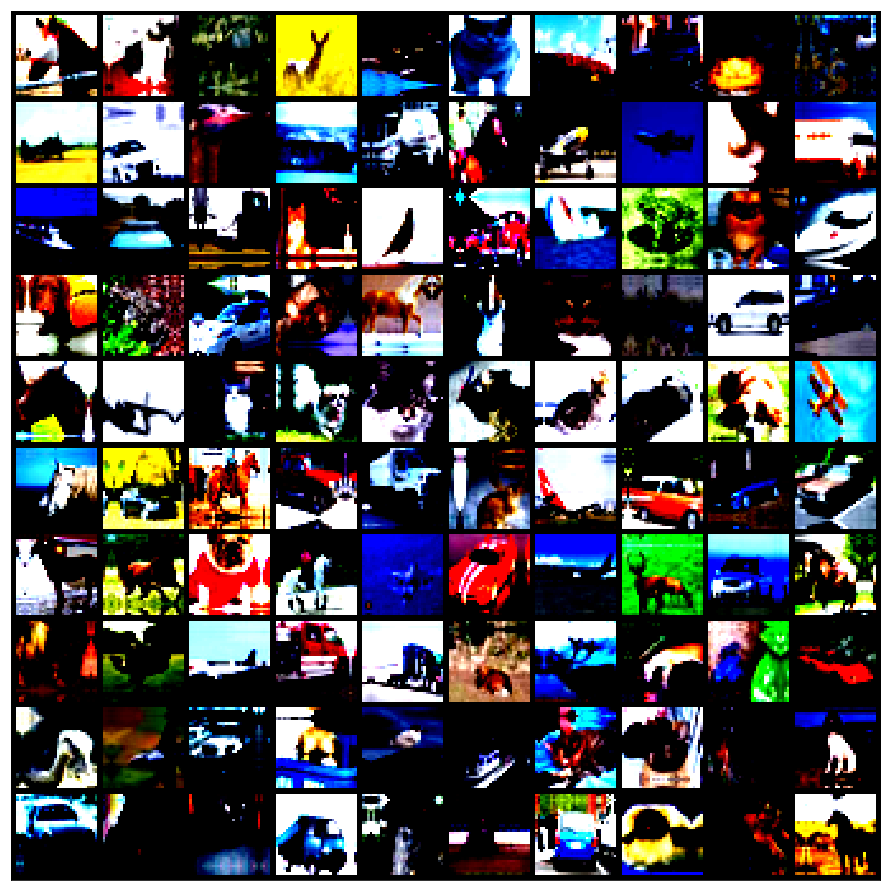

In [58]:
show_batch(train_dl)

The colors seem out of place because of the normalization. Note that normalization is also applied during inference. If you look closely, you can see the cropping and reflection padding in some of the images. Horizontal flip is a bit difficult to detect from visual inspection.

## Model with Residual Blocks and Batch Normalization

We'll use a significatly larger model this time, called the WideResNet22, which has 22 convolutional layers. However, one of the key changes to our model is the addition of the **resudial block**, which adds the original input back to the output feature map obtained by passing the input through one or more convolutional layers.

<img src="https://miro.medium.com/max/1140/1*D0F3UitQ2l5Q0Ak-tjEdJg.png">

Here is a very simply Residual block:

In [41]:
import torch.nn as nn
import torch.nn.functional as F

In [32]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out + x)

In [33]:
simple_resnet = SimpleResidualBlock()

for images, labels in train_dl:
    out = simple_resnet(images)
    print(out.shape)
    break

torch.Size([256, 3, 32, 32])


This seeming small change produces a drastic improvement in the performance of the model. Here's a great blog post explaining why and how residual blocks work: https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec .

Also, after each convolutional layer, we'll add a batch normalization layer. Here's a good explanation of batch normalization: https://towardsdatascience.com/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd


We'll define a series of helper functions to create the WideResNet22 network, which has the following structure:

<img src="https://miro.medium.com/max/2500/1*gOyiFYGHMAEDlyoAIhkWkA.png">


In [34]:
def conv_2d(ni, nf, stride=1, ks=3):
    return nn.Conv2d(in_channels=ni, out_channels=nf, 
                     kernel_size=ks, stride=stride, 
                     padding=ks//2, bias=False)

def bn_relu_conv(ni, nf):
    return nn.Sequential(nn.BatchNorm2d(ni), 
                         nn.ReLU(inplace=True), 
                         conv_2d(ni, nf))

class ResidualBlock(nn.Module):
    def __init__(self, ni, nf, stride=1):
        super().__init__()
        self.bn = nn.BatchNorm2d(ni)
        self.conv1 = conv_2d(ni, nf, stride)
        self.conv2 = bn_relu_conv(nf, nf)
        self.shortcut = lambda x: x
        if ni != nf:
            self.shortcut = conv_2d(ni, nf, stride, 1)
    
    def forward(self, x):
        x = F.relu(self.bn(x), inplace=True)
        r = self.shortcut(x)
        x = self.conv1(x)
        x = self.conv2(x) * 0.2
        return x.add_(r)

In [37]:
def make_group(N, ni, nf, stride):
    start = ResidualBlock(ni, nf, stride)
    rest = [ResidualBlock(nf, nf) for j in range(1, N)]
    return [start] + rest

class Flatten(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, x): return x.view(x.size(0), -1)

class WideResNet(nn.Module):
    def __init__(self, n_groups, N, n_classes, k=1, n_start=16):
        super().__init__()      
        # Increase channels to n_start using conv layer
        layers = [conv_2d(3, n_start)]
        n_channels = [n_start]
        
        # Add groups of BasicBlock(increase channels & downsample)
        for i in range(n_groups):
            n_channels.append(n_start*(2**i)*k)
            stride = 2 if i>0 else 1
            layers += make_group(N, n_channels[i], 
                                 n_channels[i+1], stride)
        
        # Pool, flatten & add linear layer for classification
        layers += [nn.BatchNorm2d(n_channels[3]), 
                   nn.ReLU(inplace=True), 
                   nn.AdaptiveAvgPool2d(1), 
                   Flatten(), 
                   nn.Linear(n_channels[3], n_classes)]
        
        self.features = nn.Sequential(*layers)
        
    def forward(self, x): return self.features(x)
    
def wrn_22(): 
    return WideResNet(n_groups=3, N=3, n_classes=10, k=6)

In [65]:
model = wrn_22()

In [66]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([256, 3, 32, 32])
out.shape: torch.Size([256, 10])


## Training the model

This time, we'll use some functions from the FastAI library, which builds on top of PyTorch and offers many utilities, including a powerful & customizable training loop with learning rate scheduling.

Learning rate scheduling refers to the process of dynamically changing the learning rate while the model is being trained. There are many strategies for changing the learning rate during training, and the one we'll use is called the 1-cycle policy. We start out with a low learning rate, then gradually increase it linearly to high value for about half of the training, and then slowly bring it to the original value. At the end, we train for few iterations with a very low learning rate.

<img src="https://sgugger.github.io/images/art5_lr_schedule.png">

Here's a great explanation of the 1-cycle policy: https://sgugger.github.io/the-1cycle-policy.html


In [67]:
from fastai.basic_data import DataBunch
from fastai.train import Learner
from fastai.metrics import accuracy

First, we create a `DataBunch` object to using the data loaders we created previously, and then we create a `Learner` object using the data bunch, model and a loss function.

In [68]:
data = DataBunch(train_dl, valid_dl)
learner = Learner(data, model, loss_func=F.cross_entropy, metrics=[accuracy])
learner.clip = 0.1

The statement `learner.clip = 0.1` is used to perform gradient clipping i.e. it limits the values of gradients to the range `[-1,1]`, thus preventing the undesirable changes in the parameters (weights & biases) due to large gradient values.

FastAI also provides a helpful learning rate finder, which tries a range of learning rates, and helps you select a good learning rate by looking at the graph of loss vs. learning rate.

In [69]:
learner.lr_find()

epoch     train_loss  valid_loss  accuracy  time    
0         7.168613    #na#        00:30     
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


/opt/conda/lib/python3.6/site-packages/fastai/sixel.py:16: UserWarning: You could see this plot with `libsixel`. See https://github.com/saitoha/libsixel
  warn("You could see this plot with `libsixel`. See https://github.com/saitoha/libsixel")


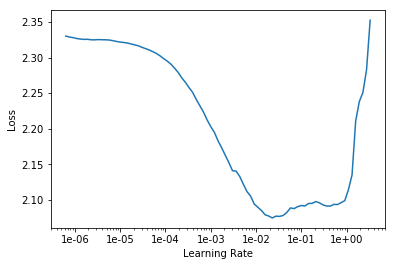

In [71]:
learner.recorder.plot()

Based on the above graph, it seems like a learning rate of `5e-3` leads to the fastest reduction in loss.

To train the model using the 1-cycle policy, we use the `.fit_one_cycle` method, and pass in the no. of epochs and the maximum learning rate. We also use [weight decay](https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab), which is yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function.

In [73]:
learner.fit_one_cycle(9, 5e-3, wd=1e-4)

epoch     train_loss  valid_loss  accuracy  time    
0         1.260158    1.319870    0.533700  00:59     
1         0.936176    1.154585    0.597000  00:59     
2         0.732852    0.820953    0.721100  00:59     
3         0.590391    0.637800    0.775400  00:59     
4         0.463658    0.486538    0.834400  00:59     
5         0.367022    0.414743    0.859500  00:59     
6         0.275758    0.310053    0.892600  00:59     
7         0.208456    0.269762    0.907900  00:59     
8         0.179152    0.265154    0.909700  00:59     


As you can see, the model quickly reaches an accuracy of over 90% in just 9 epochs. It is quite a feat, considering that our simple CNN model struggled to reach 60% accuracy even after training for a long time.

In fact, if we continue to train this model for longer, it will soon reach an accuracy of around 95%, which is quite close to the state of the art. The model and techniques covered in this tutorial were actually used by the FastAI team for their submission to the Stanform DawnBench competition.

Let's plot the learning rates, losses & accuracies of the model to get a better sense of the training process.

/opt/conda/lib/python3.6/site-packages/fastai/sixel.py:16: UserWarning: You could see this plot with `libsixel`. See https://github.com/saitoha/libsixel
  warn("You could see this plot with `libsixel`. See https://github.com/saitoha/libsixel")


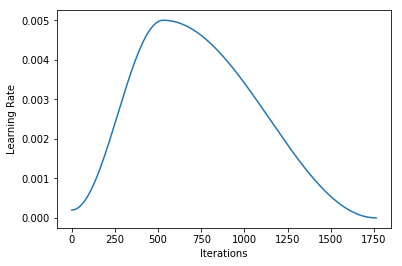

In [74]:
learner.recorder.plot_lr()

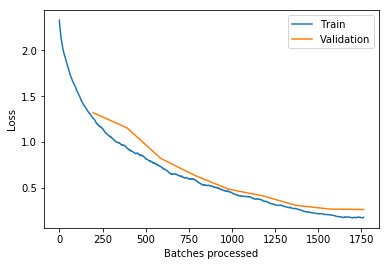

In [75]:
learner.recorder.plot_losses()

/opt/conda/lib/python3.6/site-packages/fastai/sixel.py:16: UserWarning: You could see this plot with `libsixel`. See https://github.com/saitoha/libsixel
  warn("You could see this plot with `libsixel`. See https://github.com/saitoha/libsixel")


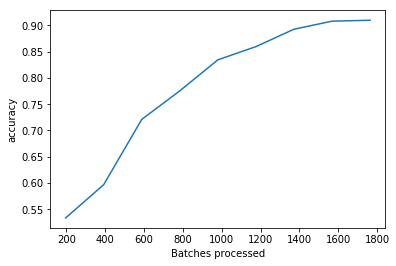

In [76]:
learner.recorder.plot_metrics()

Let's also save the weights of the model to disk, so we can avoid training the model again from scratch if we need to use it for inference in the future.

In [83]:
torch.save(model.state_dict(), 'cifar10-wrn22.pth')